In [5]:
#!/usr/bin/env python
# coding=utf-8
# Copyright 2018 Google AI, Google Brain and Carnegie Mellon University Authors and the HuggingFace Inc. team.
# Copyright (c) 2018, NVIDIA CORPORATION.  All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
""" Conditional text generation with the auto-regressive models of the library (GPT/GPT-2/CTRL/Transformer-XL/XLNet)
"""
import argparse
import logging


import numpy as np
from cat.llama_og import get_llama_cats
# from griffin.gemma import get_gemma_griffin
# from griffin.mistral import get_mistral_griffin
# from griffin.opt import get_opt_griffin

import torch
import torch.nn.functional as F
import json
import tqdm
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoConfig
from rouge import Rouge



logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO,
)
logger = logging.getLogger(__name__)


def get_distribution(logits, temperature, epsilon=1e-8):
    logits = logits  # Move logits to the device
    logits /= (temperature + epsilon)
    probability = F.softmax(logits, dim=-1)
    return probability

# %%
def sample(logits, temperature):
    output = get_distribution(logits, temperature)
    output = torch.multinomial(output, num_samples=1)
    return output.squeeze(1)



def set_seed(args):
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)

models_sizes_dict = {
    'opt': ['125m', '350m', '1.3b', '2.7b', '6.7b', '13b', '30b', '66b'],
    'llama2': ['7b', '13b', '70b'],
    'relu_llama2': ['7B', '13B', '70B'],
    'gemma': ['2b', '7b'],
    'mistral': ['7B'],
}

hugging_name_dict = {
    'opt': lambda x: f'facebook/opt-{x}',
    'llama2': lambda x: f'meta-llama/Llama-2-{x}-hf', 
    'relu_llama2': lambda x: f"SparseLLM/ReluLLaMA-{x}",
    'gemma': lambda x: f'google/gemma-{x}',
    'mistral': lambda x: f'mistralai/Mistral-{x}-v0.1',
}


modify_dict = {
    # 'opt': get_opt_griffin,
    'llama2': get_llama_cats,
    'relu_llama2': get_llama_cats,
    # 'gemma': get_gemma_griffin,
    # 'mistral': get_mistral_griffin,
}


def set_seed(args):
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(args.seed)

In [6]:
density = 0.5
selection_method = 'topk'
max_length=-1
k=0
max_tokens=10
seed=42
temp=0.3
greedy=False
device='cuda:1'

model_size_name = models_sizes_dict['llama2'][0]

config = AutoConfig.from_pretrained(hugging_name_dict['llama2'](model_size_name))
tokenizer = AutoTokenizer.from_pretrained(hugging_name_dict['llama2'](model_size_name), use_fast=True)
model = AutoModelForCausalLM.from_pretrained(hugging_name_dict['llama2'](model_size_name))

print("PARAMS: ", sum(p.numel() for p in model.parameters() if p.requires_grad))

Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.63it/s]

PARAMS:  6738415616


In [7]:
shots = 1
dataset = 'xsum'
sample_num=10

In [12]:

schedule_k = [density for _ in range(config.num_hidden_layers)]

if density < 1: # never enters gen so try .999 or something
    model.config.mode = 'gen'
    model.config.selection_method = selection_method
    model = modify_dict['llama2'](model, schedule_k, [1]*32)

model.half()
model.eval().to(device)

if dataset == 'cnn':
    # input_paths = [f'../data/cnn_data/cnn_dailymail_{shots}shot.jsonl']
    input_paths = [f'/home/vashistt/Desktop/GRIFFIN-vt/data/cnn_data/cnn_dailymail_{shots}shot.jsonl']
elif dataset == 'xsum':
    # input_paths = [f'../data/xsum_data/xsum_{shots}shot.jsonl']
    input_paths = [f'/home/vashistt/Desktop/GRIFFIN-vt/data/xsum_data/xsum_1shot_100.jsonl']
else:
    raise NotImplementedError

if max_length == -1:
    max_length = config.max_position_embeddings
    # max_length = 

# Logging or return
if max_length == -1:
    max_length = config.max_position_embeddings

requests = []
for input_path in input_paths:
        with open(input_path, 'r') as f:
            for line in f:
                if line.strip() != '':
                    requests.append(json.loads(line))

requests = requests[:sample_num]


skipped=0
n_v_all_layer = []

KeyboardInterrupt: 

In [81]:
tokenized_requests = []
for i, request in enumerate(tqdm.tqdm(requests)):        
    stop = ['###']
    temperature = temp
    label = request['summary_gt']
    prompt = request['article']
    max_tokens = max_tokens
    result = {}
    
    input_ids = tokenizer(prompt, add_special_tokens=False, return_tensors='pt').input_ids.to(model.device)
    original_input_len = len(input_ids[0])

    if len(input_ids[0]) > max_length - max_tokens:
        skipped += 1
        print('skipped', skipped)
    else:
        tokenized_requests.append({'input_ids': input_ids.to(device)})

100%|██████████| 10/10 [00:00<00:00, 676.98it/s]


In [82]:
print(tokenized_requests[0]['input_ids'].shape)
print(tokenized_requests[3]['input_ids'].shape)

torch.Size([1, 1087])
torch.Size([1, 329])


In [83]:
v_values = {}

def get_activation(name):
    def hook(model, input, output):
        v = model.act_fn(model.gate_proj(input[0]))
        if name not in v_values:
            v_values[name] = []
        v_values[name].append(v.detach().cpu().numpy())
    return hook

In [84]:
# Register hooks to MLP layers
for i, layer in enumerate(model.model.layers):
    layer.mlp.register_forward_hook(get_activation(f'layer_{i}_v'))

# Iterate over tokenized_requests and pass inputs through the model
for inputs in tokenized_requests:
    outputs = model(**inputs)

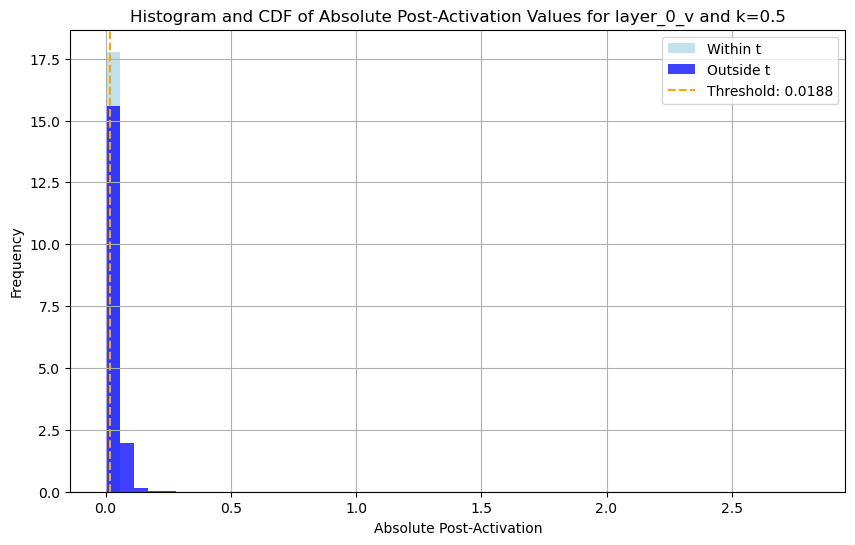

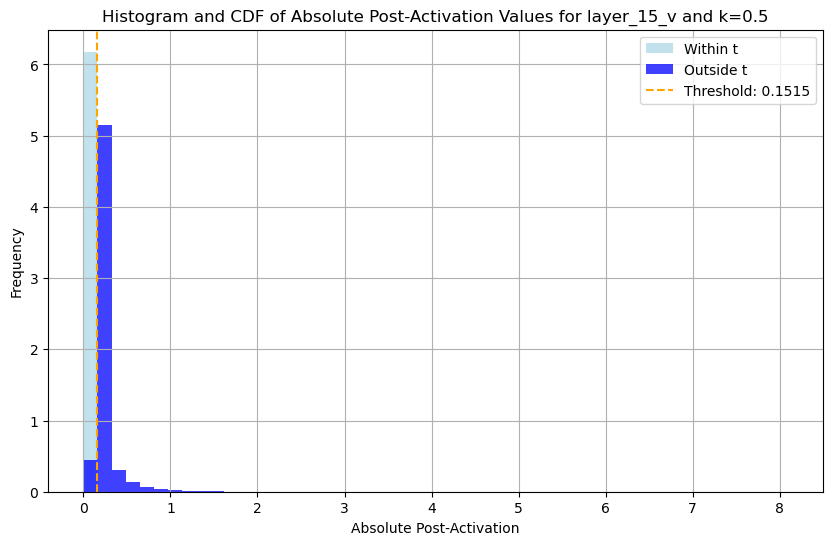

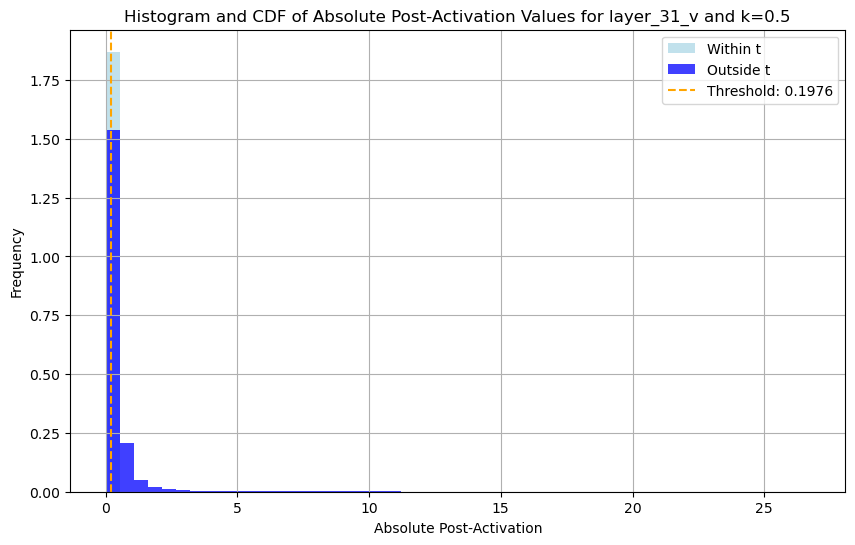

In [67]:
k = 0.5 
layer_threshold_05= {}
for name, v_list in v_values.items():
    all_v = np.concatenate(v_list, axis=1).flatten()
    abs_v = np.abs(all_v)

    # Calculate histogram
    hist, bins = np.histogram(abs_v, bins=50, density=True)
    # bin_centers = (bins[:-1] + bins[1:]) / 2

    # Calculate CDF
    sorted_abs_v = np.sort(abs_v)
    cdf = np.arange(1, len(sorted_abs_v) + 1) / len(sorted_abs_v)

    # Find the value where the CDF is >= k
    cdf_threshold_index = np.searchsorted(cdf, k)
    cdf_threshold_value = sorted_abs_v[cdf_threshold_index]
    layer_threshold_05[name] = cdf_threshold_value
    
    if ('layer_0' in name) or ('layer_15' in name) or ('layer_31' in name):
        plt.figure(figsize=(10, 6))

        within_threshold = abs_v <= cdf_threshold_value
        outside_threshold = abs_v > cdf_threshold_value

        plt.hist(abs_v[within_threshold], bins=bins, density=True, alpha=0.75, label='Within t', color='lightblue')
        plt.hist(abs_v[outside_threshold], bins=bins, density=True, alpha=0.75, label='Outside t', color='blue')

        plt.axvline(x=cdf_threshold_value, color='orange', linestyle='--', label=f'Threshold: {cdf_threshold_value:.4f}')
        
        plt.xlabel('Absolute Post-Activation')
        plt.ylabel('Frequency')
        plt.title(f'Histogram and CDF of Absolute Post-Activation Values for {name} and k={k}')
        plt.legend(loc='upper right')
        plt.grid(True)
        # max_x_value = cdf_threshold_value * 2
        # plt.xlim(0, max_x_value)
        plt.show()

In [74]:
import numpy as np

print(layer_threshold_05)
# Convert float16 values to float32
layer_threshold_05_converted = {k: float(np.float32(v)) for k, v in layer_threshold_05.items()}
# Save to a txt file
with open('layer_threshold_05.txt', 'w') as f:
    f.write(json.dumps(layer_threshold_05_converted))

{'layer_0_v': 0.01883, 'layer_1_v': 0.0362, 'layer_2_v': 0.04767, 'layer_3_v': 0.06335, 'layer_4_v': 0.0806, 'layer_5_v': 0.09705, 'layer_6_v': 0.11426, 'layer_7_v': 0.1254, 'layer_8_v': 0.1278, 'layer_9_v': 0.1315, 'layer_10_v': 0.1348, 'layer_11_v': 0.1394, 'layer_12_v': 0.1403, 'layer_13_v': 0.1455, 'layer_14_v': 0.1462, 'layer_15_v': 0.1515, 'layer_16_v': 0.1617, 'layer_17_v': 0.1666, 'layer_18_v': 0.1704, 'layer_19_v': 0.1686, 'layer_20_v': 0.1772, 'layer_21_v': 0.177, 'layer_22_v': 0.1805, 'layer_23_v': 0.1792, 'layer_24_v': 0.1808, 'layer_25_v': 0.1826, 'layer_26_v': 0.1866, 'layer_27_v': 0.19, 'layer_28_v': 0.1931, 'layer_29_v': 0.1956, 'layer_30_v': 0.2002, 'layer_31_v': 0.1976}


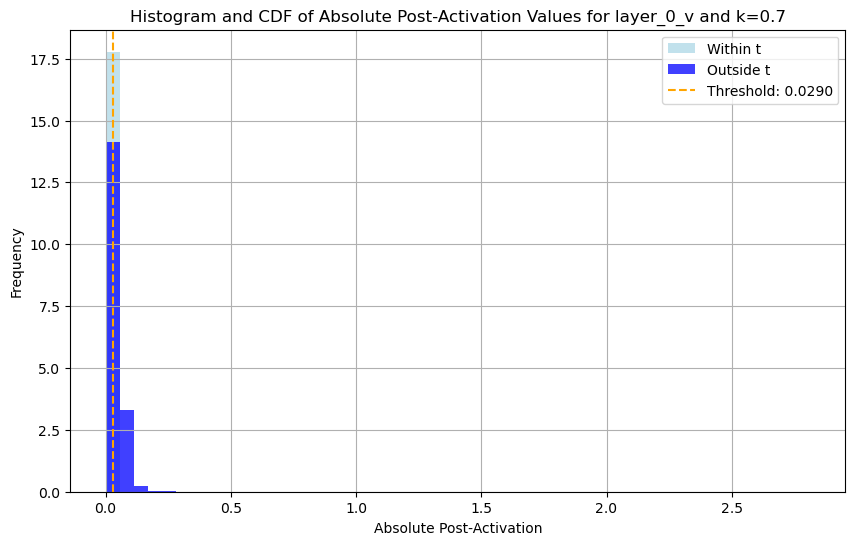

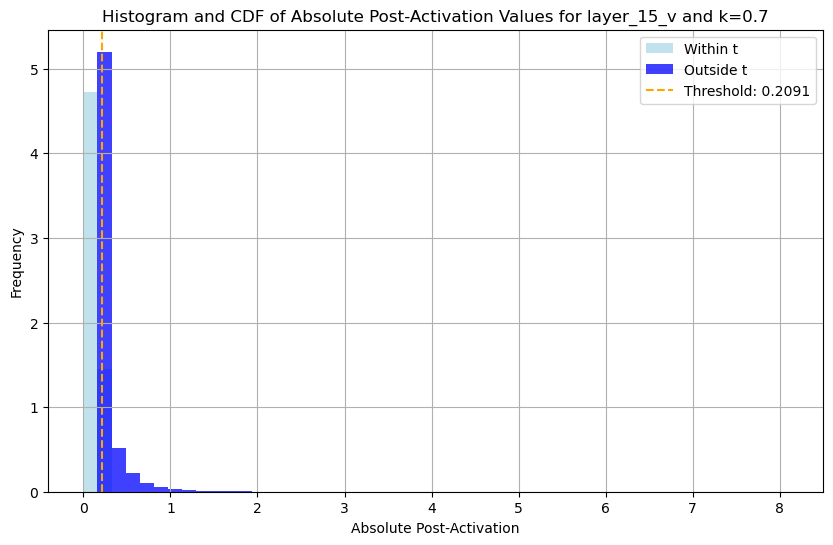

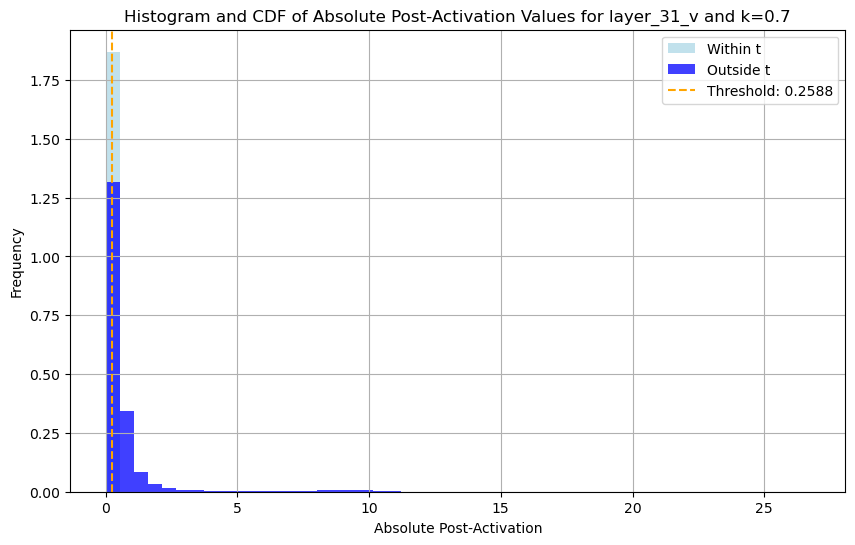

In [86]:
k = 0.7
layer_threshold_07= {}
for name, v_list in v_values.items():
    all_v = np.concatenate(v_list, axis=1).flatten()
    abs_v = np.abs(all_v)

    # Calculate histogram
    hist, bins = np.histogram(abs_v, bins=50, density=True)
    # bin_centers = (bins[:-1] + bins[1:]) / 2

    # Calculate CDF
    sorted_abs_v = np.sort(abs_v)
    cdf = np.arange(1, len(sorted_abs_v) + 1) / len(sorted_abs_v)

    # Find the value where the CDF is >= k
    cdf_threshold_index = np.searchsorted(cdf, k)
    cdf_threshold_value = sorted_abs_v[cdf_threshold_index]
    layer_threshold_07[name] = cdf_threshold_value
    
    if ('layer_0' in name) or ('layer_15' in name) or ('layer_31' in name):
        plt.figure(figsize=(10, 6))

        within_threshold = abs_v <= cdf_threshold_value
        outside_threshold = abs_v > cdf_threshold_value

        plt.hist(abs_v[within_threshold], bins=bins, density=True, alpha=0.75, label='Within t', color='lightblue')
        plt.hist(abs_v[outside_threshold], bins=bins, density=True, alpha=0.75, label='Outside t', color='blue')

        plt.axvline(x=cdf_threshold_value, color='orange', linestyle='--', label=f'Threshold: {cdf_threshold_value:.4f}')
        
        plt.xlabel('Absolute Post-Activation')
        plt.ylabel('Frequency')
        plt.title(f'Histogram and CDF of Absolute Post-Activation Values for {name} and k={k}')
        plt.legend(loc='upper right')
        plt.grid(True)
        plt.show()

In [88]:
import numpy as np

print(layer_threshold_07)
# Convert float16 values to float32
layer_threshold_07_converted = {k: float(np.float32(v)) for k, v in layer_threshold_07.items()}
# Save to a txt file
with open('layer_threshold_07.txt', 'w') as f:
    f.write(json.dumps(layer_threshold_07_converted))

{'layer_0_v': 0.02899, 'layer_1_v': 0.05496, 'layer_2_v': 0.0729, 'layer_3_v': 0.0952, 'layer_4_v': 0.11896, 'layer_5_v': 0.1401, 'layer_6_v': 0.1617, 'layer_7_v': 0.1754, 'layer_8_v': 0.1799, 'layer_9_v': 0.1847, 'layer_10_v': 0.1895, 'layer_11_v': 0.1943, 'layer_12_v': 0.1959, 'layer_13_v': 0.2019, 'layer_14_v': 0.203, 'layer_15_v': 0.2091, 'layer_16_v': 0.219, 'layer_17_v': 0.2231, 'layer_18_v': 0.227, 'layer_19_v': 0.2266, 'layer_20_v': 0.2341, 'layer_21_v': 0.2344, 'layer_22_v': 0.2382, 'layer_23_v': 0.2377, 'layer_24_v': 0.2395, 'layer_25_v': 0.2411, 'layer_26_v': 0.2441, 'layer_27_v': 0.2468, 'layer_28_v': 0.2496, 'layer_29_v': 0.2517, 'layer_30_v': 0.2559, 'layer_31_v': 0.2588}


In [87]:
print(layer_threshold_07)

{'layer_0_v': 0.02899, 'layer_1_v': 0.05496, 'layer_2_v': 0.0729, 'layer_3_v': 0.0952, 'layer_4_v': 0.11896, 'layer_5_v': 0.1401, 'layer_6_v': 0.1617, 'layer_7_v': 0.1754, 'layer_8_v': 0.1799, 'layer_9_v': 0.1847, 'layer_10_v': 0.1895, 'layer_11_v': 0.1943, 'layer_12_v': 0.1959, 'layer_13_v': 0.2019, 'layer_14_v': 0.203, 'layer_15_v': 0.2091, 'layer_16_v': 0.219, 'layer_17_v': 0.2231, 'layer_18_v': 0.227, 'layer_19_v': 0.2266, 'layer_20_v': 0.2341, 'layer_21_v': 0.2344, 'layer_22_v': 0.2382, 'layer_23_v': 0.2377, 'layer_24_v': 0.2395, 'layer_25_v': 0.2411, 'layer_26_v': 0.2441, 'layer_27_v': 0.2468, 'layer_28_v': 0.2496, 'layer_29_v': 0.2517, 'layer_30_v': 0.2559, 'layer_31_v': 0.2588}


In [96]:
a = torch.randn(3,6)
b = torch.randn(6,3)

In [99]:
(a@b).shape

torch.Size([3, 3])

In [92]:
(a * b.T).shape

torch.Size([3, 6])